In [21]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Define dataset path
data_dir = r"C:\Users\kancharr\Documents\Jupyter\data\GuavaDiseaseDataset\GuavaDiseaseDataset"

In [12]:
# Define image transformations
# Resize to 224x224 and normalize for models like ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
])

In [13]:
# Load datasets
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)

In [16]:
# DataLoader for batch processing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [19]:
# Print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Example of iterating through the data
for images, labels in train_loader:
    print(f"Batch size: {images.size()}, Labels: {labels}")
    break

Number of training samples: 2647
Number of test samples: 382
Classes: ['Anthracnose', 'fruit_fly', 'healthy_guava']
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 2, 1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 2])


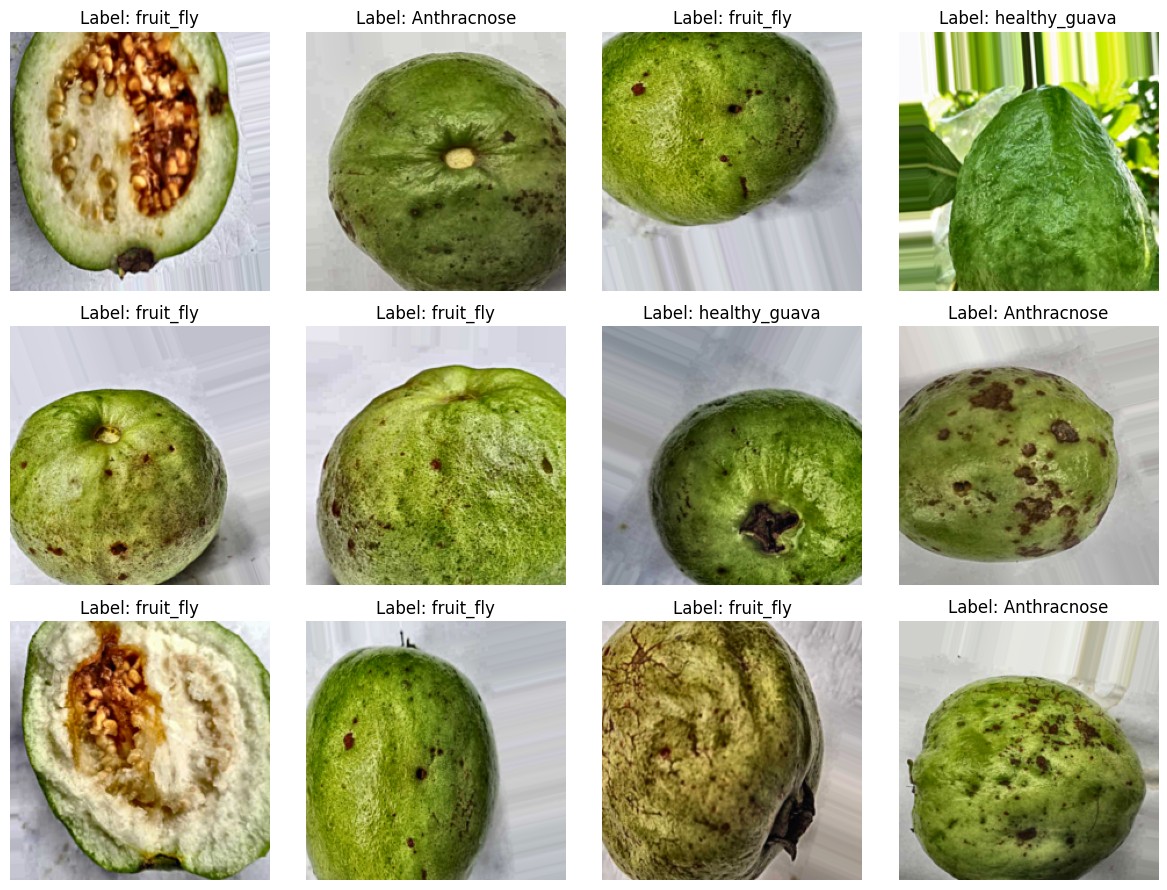

In [22]:
# Function to display images
def show_images(images, labels, class_names):
    # Unnormalize images for visualization
    images = images.permute(0, 2, 3, 1)  # Change from (N, C, H, W) to (N, H, W, C)
    images = images * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Create a 3x4 grid for 12 images
    axes = axes.flatten()
    
    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img.numpy())  # Convert tensor to numpy array
        ax.set_title(f"Label: {class_names[lbl]}")
        ax.axis('off')  # Turn off axes
    
    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))  # Get the first batch from the DataLoader
class_names = train_dataset.classes  # Get class names from the dataset

# Plot 12 images
show_images(images[:12], labels[:12], class_names)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [85]:
# Define the CNN model
class ModifiedCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(ModifiedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3x224x224 -> Output: 32x224x224
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                 # Output: 32x112x112
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Input: 32x112x112 -> Output: 64x112x112
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                 # Output: 64x56x56
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # Input: 64x56x56 -> Output: 128x56x56
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)                  # Output: 128x28x28
        
        # Batch normalization before the fully connected layers
        self.bn_fc = nn.BatchNorm1d(128 * 7 * 7)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 124)  # 128 feature maps of size 28x28
        self.fc2 = nn.Linear(124, num_classes)    # Output layer for 3 classes

    def forward(self, x):
        # First conv layer with ReLU and MaxPooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second conv layer with ReLU and MaxPooling
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Third conv layer with MaxPooling (without ReLU as per your request)
        x = self.conv3(x)
        x = self.pool3(x)
        print(f"Shape after pool3: {x.shape}")
        # Flatten the tensor
        x = x.view(-1, 128 * 28 * 28)
        
        # Batch normalization before fully connected layers
        x = self.bn_fc(x)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [86]:
# Initialize the model
model = SimpleCNN(num_classes=3)

# Print the model architecture
print(model)

# Example usage

model = model.to(device)

# Dummy input to test the model
dummy_input = torch.randn(32, 3, 224, 224).to(device)  # Batch size: 32, 3 color channels, image size: 224x224
output = model(dummy_input)
print(f"Output shape: {output.shape}")  # Should be [32, 3]

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Output shape: torch.Size([128, 3])


In [87]:
import torch.optim as optim

In [88]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
criterion = nn.CrossEntropyLoss()                     # CrossEntropyLoss for multi-class classification

In [89]:
# Hyperparameters
num_epochs = 25

In [90]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and print training metrics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
 

ValueError: Expected input batch_size (128) to match target batch_size (32).